# Restricted Boltzmann Machines (RBM)을 활용한 MNIST 이미지 복원

##### 원본 코드 출처 : https://github.com/MichelDeudon/RBM-for-MNIST

## 1. 패키지 로드

In [14]:
import tensorflow as tf
import os 
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm
import matplotlib.pyplot as plt

## 2. 필요 함수 및 클래스 정의 

In [15]:

def sample(probabilities, mode='bernoulli'):
    ''' Sample a tensor based on the probabilities (A tensor given by get_probabilities)'''
    if mode=='bernoulli':
        return tf.floor(probabilities + tf.random_uniform(tf.shape(probabilities), 0, 1))


# Simple RBM class
class RBM:

    #Class 변수 초기화 
    def __init__(self, n_visible, n_hidden, lr, epochs, mode='bernoulli'):
        ''' Initialize a model for an RBM with one layer of hidden units '''
        self.mode = mode # bernoulli or gaussian RBM
        self.n_hidden = n_hidden #  Number of hidden nodes
        self.n_visible = n_visible # Number of visible nodes
        self.lr = lr # Learning rate for the CD algorithm
        self.epochs = epochs # Number of iterations to run the algorithm for

        # 784 by 144 dim 가중치random normal로 초기화 
        with tf.name_scope('Weights'):
            self.W = tf.Variable(tf.random_normal([self.n_visible, self.n_hidden], mean=0., stddev=4 * np.sqrt(6. / (self.n_visible + self.n_hidden))), name="weights")
        
        # 가중치에 대한 분포도 변화를 모니터링 하게끔 하기 위함
        tf.summary.histogram('weights',self.W)
        
        # 1 by 784 dim visible layer 0으로 초기화
        self.vb = tf.Variable(tf.zeros([1, self.n_visible]),tf.float32, name="visible_bias")
        
        # 1 by 144 dim hidden layer 0으로 초기화
        self.hb = tf.Variable(tf.zeros([1, self.n_hidden]),tf.float32, name="hidden_bias")

    
    def get_probabilities(self, layer, val):
        ''' Return a tensor of probabilities associated with the layer specified'''
        if layer == 'hidden':
            #vsible layer를 입력하여 hidden layer의 probability를 계산
            with tf.name_scope("Hidden_Probabilities"):
                if self.mode=='bernoulli':
                    return tf.nn.sigmoid(tf.matmul(val, self.W) + self.hb)
            
            # hidden layer의 binary vector를 받아 visible layer의 값(0~1)을 를 계산 
        elif layer == 'visible':
            with tf.name_scope("Visible_Probabilities"):
                return tf.nn.sigmoid(tf.matmul(val, tf.transpose(self.W)) + self.vb)

    # K-step Contrastive Divergence using Gibbs sampling.
    def CD(self, v, K=1):
        ''' K-step Contrastive Divergence using Gibbs sampling. Return parameters update. '''
        
        with tf.name_scope("Contrastive_Divergence"):
            # Visible layer를 넣어 hidden layer의 probablilties를 계산 
            h_prob = self.get_probabilities('hidden', v)
            
            # Hidden layer의 probability를 사용하여 Hidden layer를 Sampling 0,1을 144개 sampling 함
            h_state = sample(h_prob, mode=self.mode)
            
            # http://ofai.at/~jan.schlueter/pubs/2014_techrep_rbm.pdf 
            # Bernouli - Bernouli model 의 (12)번 equation 앞부분 dW 를 계산 하기 위함
            pos_divergence = tf.matmul(tf.transpose(v), h_prob) # Positive Divergence + h(v).v^T
            
            # Visible layer -> multipy weight and plus bias -> signmod -> hidden layer probability ->  sample binary 
            # -> multipy weight and plus bias -> sigmoid -> visible layer value (0~1)
            fake_v_prob = self.get_probabilities('visible', h_state)
            fake_v_state = fake_v_prob #sample(fake_v_prob)

            # visible layer value -> multipy weight and plus bias -> sigmoid -> hidden layer probability 
            fake_h_prob = self.get_probabilities('hidden', fake_v_state)
            #  sample binary 
            fake_h_state = sample(fake_h_prob, mode=self.mode)
            
            #K > 1 일 때 위 과정을 반복
            for i in range(K-1): # Number of steps to run the algorithm

                fake_v_prob = self.get_probabilities('visible', fake_h_state)
                fake_v_state = fake_v_prob #sample(fake_v_prob)

                fake_h_prob = self.get_probabilities('hidden', fake_v_state)
                fake_h_state = sample(fake_h_prob, mode=self.mode)
                
            
            # Bernouli - Bernouli model 의 (12)번 equation 뒷부분 dW 를 계산 하기 위함
            neg_divergence = tf.matmul(tf.transpose(fake_v_state), fake_h_prob) # Negative Divergence - h(v').v'^T

            dW = pos_divergence-neg_divergence
            dvb = v-fake_v_state
            dhb = h_prob-fake_h_prob

            # Similarity between reconstructed visible layer and input during training. 
            self.rec_error = tf.reduce_mean(tf.squared_difference(v, fake_v_state))
            tf.summary.scalar('reconstruction_error', self.rec_error)

            self.div = tf.reduce_mean(tf.abs(dW))
            tf.summary.scalar('weights_increment', self.div)

            return dW, dvb, dhb

    #가중치 업데이트 
    def update(self, v, K=1):
        batch_size = tf.cast(tf.shape(v)[0], tf.float32) # batch size
        dW, dvb, dhb = self.CD(v, K=K) # Contrastive - Divergence 수행
        
        #CD 를 통해 얻어진 값을 활용하여 Gradient - Decent  수행 
        delta_w = (self.lr/batch_size)*dW # weight gradient
        delta_vb = (self.lr/batch_size)*(tf.reduce_sum(dvb, 0, keep_dims=True)) # visible bias gradient
        delta_hb = (self.lr/batch_size)*(tf.reduce_sum(dhb, 0, keep_dims=True)) # hidden bias gradient
        
        #가중치 업데이트
        train_op = [self.W.assign_add(delta_w), self.vb.assign_add(delta_vb), self.hb.assign_add(delta_hb)] 
        return train_op

    
    def gibbs(self, steps, v):
        ''' Use the Gibbs sampler for a network of hidden and visible units. Return a sampled version of the input'''
        with tf.name_scope("Gibbs_sampling"):
            for i in range(steps): # Number of steps to run the algorithm
                hidden_p = self.get_probabilities('hidden', v) # v: input data
                h = sample(hidden_p, mode=self.mode)

                visible_p = self.get_probabilities('visible', h)
                v = visible_p
                #v = sample(visible_p)
            return visible_p


    def free_energy(self, v):
        ''' Compute the free energy for a visible state'''
        vbias_term = tf.matmul(v, tf.transpose(self.vb))
        x_b = tf.matmul(v, self.W) + self.hb
        hidden_term = tf.reduce_sum(tf.log(1 + tf.exp(x_b)))
        return - hidden_term - vbias_term


    def get_feature_map(self):
        ''' Return hidden features'''
        ft_map = {}
        for k in range(self.n_hidden):
            ft_map[k] = self.get_probabilities('visible', tf.expand_dims(tf.one_hot(k+1, self.n_hidden),0))
        return ft_map



## 3. MNIST 데이터 로드 및 RBM 모델 설정

In [16]:
# MNIST 데이터 로드
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

# RBM 모델 초기화 및 구조 생성 
rbm_model = RBM(n_visible = 784, n_hidden = 144, lr = tf.constant(0.05, tf.float32), epochs = 10000, mode='bernoulli')

# Visible layer의 공간 설정
v = tf.placeholder(tf.float32, shape=[None, rbm_model.n_visible], name="visible_layer")

# 업데이트 룰 설정 
k=1
train_op = rbm_model.update(v, K=k)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## 4. 학습 결과 저장 관련 설정 (Tensorboard)

In [17]:
# Free energy
energy = rbm_model.free_energy(v=v)
tf.summary.scalar('free_energy', tf.reduce_mean(energy))

# Merge summaries for Tensorboard visualization
summary = tf.summary.merge_all()

# Save & restore all the variables.
saver = tf.train.Saver({"weights":rbm_model.W, "visible_bias":rbm_model.vb, "hidden_bias":rbm_model.hb})

## 5. RBM 모형 학습

In [18]:
# Tensorflow session 시작
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# 결과 저장 경로 
test_writer = tf.summary.FileWriter(os.getcwd()+'/RBM_logs/MNIST_Bernoulli',sess.graph)

# 학습
for epoch in tqdm(range(rbm_model.epochs)):
    if epoch % 100 == 0:
        result = sess.run([rbm_model.rec_error, summary], feed_dict = {v: mnist.test.images})
        if epoch % 1000 == 0: print("Reconstruction error at step {}: {:.3f}".format(epoch, result[0]))
        test_writer.add_summary(result[1],epoch)

    batchXs, batchYs = mnist.train.next_batch(32)
    sess.run(train_op, feed_dict = {v: batchXs})

save_path = saver.save(sess, os.getcwd()+"/saved_model/actor.ckpt")
print("Saving model at: %s"%(save_path))

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
Cannot set tensorflow.VariableDef.trainable to tf.float32: tf.float32 has type <class 'tensorflow.python.framework.dtypes.DType'>, but expected one of: (<class 'bool'>, <class 'numbers.Integral'>)
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
Cannot set tensorflow.VariableDef.trainable to tf.float32: tf.float32 has type <class 'tensorflow.python.framework.dtypes.DType'>, but expected one of: (<class 'bool'>, <class 'numbers.Integral'>)


C:\Users\PC\AppData\Local\conda\conda\envs\practice_env\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

Reconstruction error at step 0: 0.333


 11%|████████▎                                                                   | 1093/10000 [00:02<00:23, 373.83it/s]

Reconstruction error at step 1000: 0.024


 21%|███████████████▊                                                            | 2088/10000 [00:04<00:17, 464.48it/s]

Reconstruction error at step 2000: 0.021


 30%|██████████████████████▉                                                     | 3015/10000 [00:06<00:16, 425.53it/s]

Reconstruction error at step 3000: 0.019


 41%|███████████████████████████████                                             | 4091/10000 [00:08<00:11, 504.51it/s]

Reconstruction error at step 4000: 0.017


 50%|██████████████████████████████████████▎                                     | 5048/10000 [00:10<00:10, 453.33it/s]

Reconstruction error at step 5000: 0.017


 61%|██████████████████████████████████████████████▎                             | 6093/10000 [00:12<00:07, 491.74it/s]

Reconstruction error at step 6000: 0.016


 70%|█████████████████████████████████████████████████████▌                      | 7045/10000 [00:15<00:07, 405.27it/s]

Reconstruction error at step 7000: 0.015


 81%|█████████████████████████████████████████████████████████████▏              | 8059/10000 [00:17<00:04, 455.11it/s]

Reconstruction error at step 8000: 0.015


 91%|█████████████████████████████████████████████████████████████████████       | 9092/10000 [00:19<00:01, 469.14it/s]

Reconstruction error at step 9000: 0.014


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 472.51it/s]


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
Cannot set tensorflow.VariableDef.trainable to tf.float32: tf.float32 has type <class 'tensorflow.python.framework.dtypes.DType'>, but expected one of: (<class 'bool'>, <class 'numbers.Integral'>)
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
Cannot set tensorflow.VariableDef.trainable to tf.float32: tf.float32 has type <class 'tensorflow.python.framework.dtypes.DType'>, but expected one of: (<class 'bool'>, <class 'numbers.Integral'>)
Saving model at: C:\Users\PC\Desktop\RBM-for-MNIST-master/saved_model/actor.ckpt


## 6. 학습결과 시각화

### Hidden layer 144개의 노드 각각의 역할을 확인

In [20]:
def plot_features(ft_map):
    """ Plot MNIST features in a table."""
    len_ = int(np.sqrt(rbm_model.n_hidden))
    fig = plt.figure()
    features = [ft_map[k] for k in range(rbm_model.n_hidden)]
    for x in range(len_):
        for y in range(len_):
            ax = fig.add_subplot(len_, len_, len_*y+x+1)
            ax.matshow(features[len_*y+x].reshape((28,28)), cmap = plt.cm.gray)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

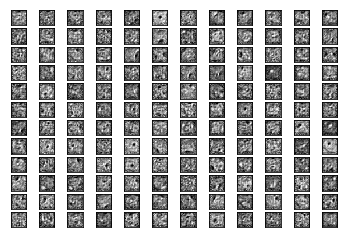

In [21]:
ft_map = sess.run(rbm_model.get_feature_map())
plot_features(ft_map)

### 원본 이미지와 복원이미지 확인

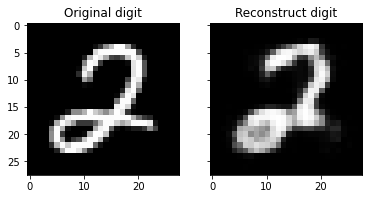

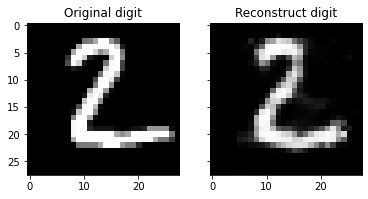

In [22]:
def show_digit(original, fake):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(original.reshape((28,28)),cmap = plt.cm.gray)
    ax1.set_title('Original digit')
    ax2.imshow(fake.reshape((28,28)),cmap = plt.cm.gray)
    ax2.set_title('Reconstruct digit')
    plt.show()

train_image = mnist.train.images[1] # from train distribution
sample_train = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: train_image.reshape(1,-1).astype(np.float32)})  
show_digit(original=train_image, fake=sample_train)  

test_image = mnist.test.images[1] # from test distribution
sample_test = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: test_image.reshape(1,-1).astype(np.float32)})    
show_digit(original=test_image, fake=sample_test)  

tf.reset_default_graph()